## 1-) Imports et configuration

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [2]:
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

GPU available: True


In [4]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


## 2-) Préparation des données CIFAR-10

### 2.1 - Chargement du dataset CIFAR-10

In [14]:
from tensorflow.keras.datasets import cifar10

# Chargement des données
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Train :", x_train.shape, y_train.shape)
print("Test  :", x_test.shape, y_test.shape)

Train : (50000, 32, 32, 3) (50000, 1)
Test  : (10000, 32, 32, 3) (10000, 1)


## 2.2 - Normalisation et constantes

In [15]:
# Normalisation en [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Hyperparamètres
IMG_SIZE   = (32, 32)   # taille native de CIFAR-10
BATCH_SIZE = 64
SEED       = 1337

## 2.3 - Création de train_ds, val_ds, test_ds (équivalent à image_dataset_from_directory)

In [16]:
import tensorflow as tf

# Numpy -> tf.data.Dataset
full_train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Split train / val (80% / 20%)
train_size = int(0.8 * len(full_train_ds))
val_size   = len(full_train_ds) - train_size

train_ds = full_train_ds.take(train_size)
val_ds   = full_train_ds.skip(train_size)

# Batch + shuffle (comme dans image_dataset_from_directory)
train_ds = train_ds.shuffle(10000, seed=SEED).batch(BATCH_SIZE)
val_ds   = val_ds.batch(BATCH_SIZE)

# Dataset de test
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## 2.4 - class_names (comme train_ds.class_names)

In [17]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck",
]

class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## 3-) Optimisation du pipeline (cache / prefetch)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare_for_training(ds):
    """
    Optimise un tf.data.Dataset pour l'entraînement :
      - cache() : garde les batches en mémoire (CIFAR-10 tient en RAM)
      - prefetch() : pipeline asynchrone CPU → GPU
    """
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_prep = prepare_for_training(train_ds)
val_ds_prep   = prepare_for_training(val_ds)
test_ds_prep  = prepare_for_training(test_ds)

## 4-) Visualisation rapide de quelques images

/tmp/ipython-input-2410450136.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_idx = int(labels[i].numpy())


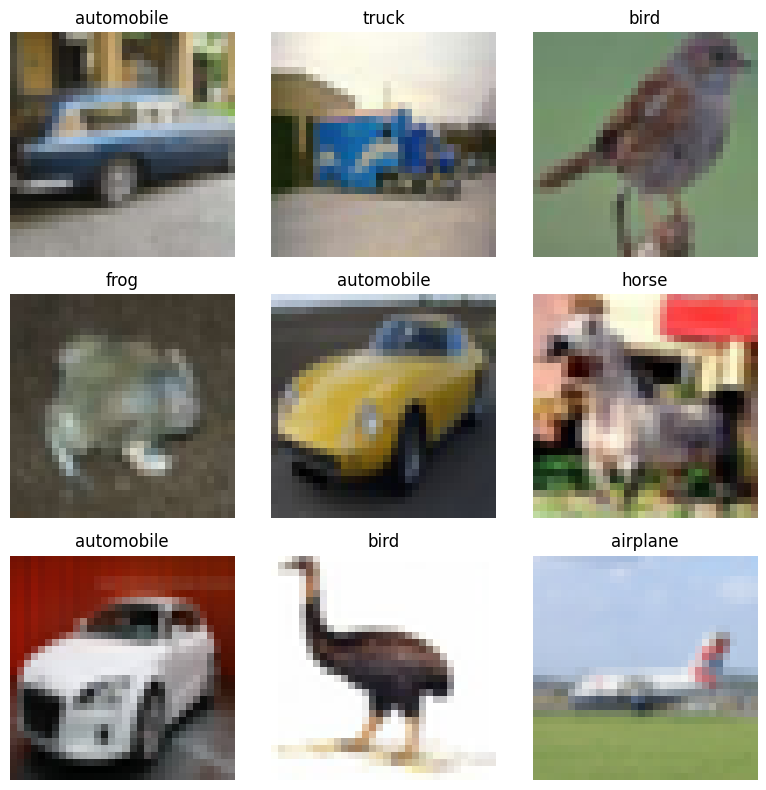

In [19]:
# 4-) Visualisation rapide de quelques images

plt.figure(figsize=(8, 8))

# On prend un seul batch du dataset d'entraînement
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # images : [0,1] -> [0,255] puis uint8
        img = (images[i] * 255).numpy().astype("uint8")
        label_idx = int(labels[i].numpy())

        plt.imshow(img)
        plt.title(class_names[label_idx])
        plt.axis("off")

plt.tight_layout()
plt.show()

## 5-) Modèle CNN simple (baseline)

In [20]:
# 5-) Modèle CNN simple (baseline) — sans double normalisation

num_classes = len(class_names)

# On n'ajoute PAS de couche Rescaling ici,
# car x_train / x_test ont déjà été divisés par 255.0 dans la section 2.2

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMG_SIZE + (3,)),   # (32, 32, 3)

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax"),
])

model_cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)

## 6-) Entrainement

In [23]:
import tensorflow as tf

EPOCHS = 20

# Callback : on arrête si la val_loss ne s’améliore plus
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,              # nb d’époques sans amélioration avant arrêt
    restore_best_weights=True,
    verbose=1,
)

history_cnn = model_cnn.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=2,               # 1 ligne par époque, plus lisible
)

# Résumé compact à la fin
print("\n--- Résumé entraînement ---")
print(f"Époques réellement effectuées : {len(history_cnn.history['loss'])}")
print(f"Meilleure val_accuracy : {max(history_cnn.history['val_accuracy']):.4f}")
print(f"Meilleure val_loss     : {min(history_cnn.history['val_loss']):.4f}")

Epoch 1/20
625/625 - 3s - 5ms/step - accuracy: 0.7487 - loss: 0.7169 - val_accuracy: 0.6985 - val_loss: 0.8913
Epoch 2/20
625/625 - 2s - 4ms/step - accuracy: 0.7599 - loss: 0.6887 - val_accuracy: 0.7005 - val_loss: 0.9079
Epoch 3/20
625/625 - 2s - 4ms/step - accuracy: 0.7706 - loss: 0.6617 - val_accuracy: 0.7015 - val_loss: 0.9014
Epoch 4/20
625/625 - 2s - 4ms/step - accuracy: 0.7825 - loss: 0.6229 - val_accuracy: 0.7091 - val_loss: 0.9259
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.

--- Résumé entraînement ---
Époques réellement effectuées : 4
Meilleure val_accuracy : 0.7091
Meilleure val_loss     : 0.8913


## 7-) Courbes d’apprentissage (CNN baseline)

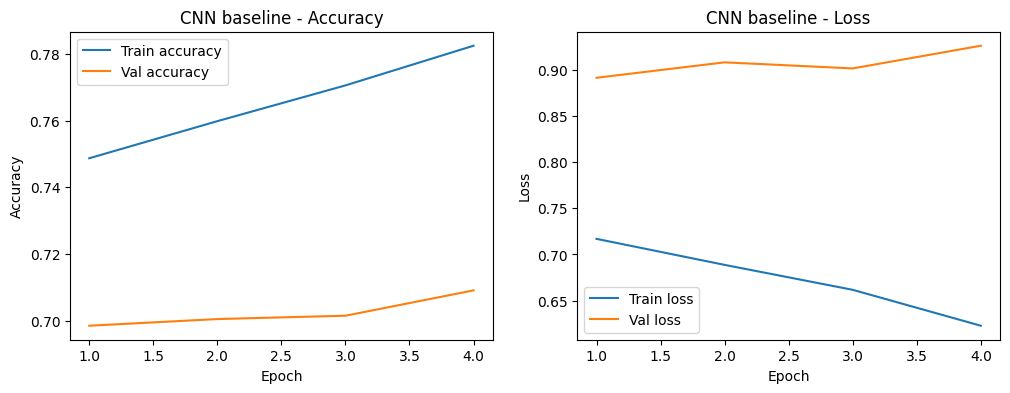

In [24]:
def plot_history(history, title_prefix="CNN baseline"):
    acc      = history.history["accuracy"]
    val_acc  = history.history["val_accuracy"]
    loss     = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs   = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Train accuracy")
    plt.plot(epochs, val_acc, label="Val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Train loss")
    plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.legend()

    plt.show()

plot_history(history_cnn, "CNN baseline")

## 8-) Évaluation détaillée sur le test set

### 8.1 - Accuracy globale sur le test set

In [25]:
test_loss, test_acc = model_cnn.evaluate(test_ds_prep)
print(f"Test loss     : {test_loss:.4f}")
print(f"Test accuracy : {test_acc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6972 - loss: 0.9016
Test loss     : 0.9156
Test accuracy : 0.6929


### 8.2 - Classification report et matrice de confusion

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

y_true = []
y_pred = []

for images, labels in test_ds_prep:
    preds = model_cnn.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
cm

              precision    recall  f1-score   support

    airplane       0.72      0.74      0.73      1000
  automobile       0.86      0.81      0.83      1000
        bird       0.52      0.63      0.57      1000
         cat       0.56      0.43      0.49      1000
        deer       0.64      0.61      0.63      1000
         dog       0.56      0.68      0.61      1000
        frog       0.85      0.70      0.77      1000
       horse       0.69      0.76      0.72      1000
        ship       0.85      0.77      0.81      1000
       truck       0.78      0.80      0.79      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



array([[740,  13,  81,  15,  20,  11,   5,  23,  59,  33],
       [ 25, 809,  12,   9,   3,  12,   2,   7,  18, 103],
       [ 57,   3, 632,  45,  83,  96,  34,  31,  10,   9],
       [ 21,   6, 115, 435,  75, 231,  44,  55,   5,  13],
       [ 27,   3, 114,  50, 612,  45,  25, 116,   7,   1],
       [ 10,   3,  67, 110,  42, 677,   7,  75,   3,   6],
       [  5,   7, 120,  63,  49,  26, 700,  10,   6,  14],
       [ 19,   3,  45,  22,  52,  80,   5, 757,   2,  15],
       [ 98,  34,  24,  13,  11,  14,   1,   9, 768,  28],
       [ 29,  61,  14,  18,  10,  18,   3,  22,  26, 799]])

### 8.3 - Visualisation de la matrice de confusion

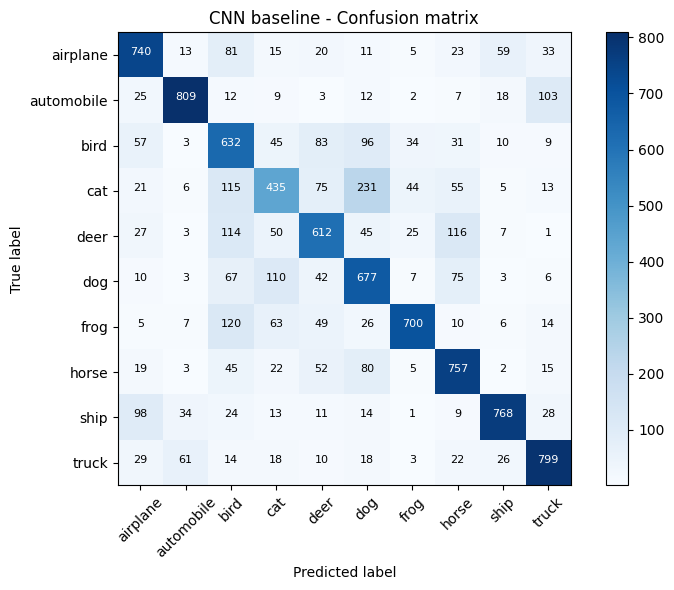

In [27]:
# Graphique matrice de confusion avec matplotlib
def plot_confusion_matrix(cm, class_names, title="CNN baseline - Confusion matrix"):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=8,
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names)

## 9-) Transfert Learning (Modèle avancé)

#### On va utiliser EfficientNetB0, un modèle léger, stable et performant pour CIFAR-10

### 9.1 - Datasets pour EfficientNetB0 (resize et préprocesseur)

In [28]:
# Préparation des datasets pour EfficientNetB0

import tensorflow as tf
from tensorflow.keras.applications import efficientnet

AUTOTUNE      = tf.data.AUTOTUNE
IMG_SIZE_TL   = (224, 224)   # taille attendue par EfficientNetB0
BATCH_SIZE_TL = BATCH_SIZE   # on peut garder 64, ou descendre à 32 si OOM
SEED          = 1337

def preprocess_efficientnet(images, labels):
    # images arrivent en [0,1] de taille (32, 32, 3) batchées
    images = tf.image.resize(images, IMG_SIZE_TL)   # (batch, 224, 224, 3)
    images = images * 255.0                         # repasse en [0,255]
    images = efficientnet.preprocess_input(images)  # préprocesseur officiel
    return images, labels

def prepare_tl(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)
    ds = ds.map(preprocess_efficientnet, num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds_tl = prepare_tl(train_ds, shuffle=True)
val_ds_tl   = prepare_tl(val_ds,   shuffle=False)
test_ds_tl  = prepare_tl(test_ds,  shuffle=False)

### 9.2 - Chargement du backbone EfficientNetB0 pré-entraîné

In [31]:
# Chargement EfficientNetB0 pré-entraîné

from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE_TL + (3,),
)

# On gèle les poids du backbone pour la phase 1
base_model.trainable = False

base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

### 9.3 - Construction du modèle complet

In [32]:
# Construction du modèle de transfert learning

num_classes = len(class_names)   # déjà défini en 2.4

inputs = tf.keras.Input(shape=IMG_SIZE_TL + (3,))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model_tl = tf.keras.Model(inputs, outputs)

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_tl.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### 9.4 - Entraînement (phase 1 : backbone gelé)

In [33]:
# Entraînement EfficientNetB0 (backbone gelé)

from tensorflow.keras.callbacks import EarlyStopping

EPOCHS_TL = 15

early_stop_tl = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1,
)

history_tl = model_tl.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=EPOCHS_TL,
    callbacks=[early_stop_tl],
    verbose=2,
)

Epoch 1/15
625/625 - 99s - 158ms/step - accuracy: 0.8161 - loss: 0.5790 - val_accuracy: 0.8836 - val_loss: 0.3406
Epoch 2/15
625/625 - 52s - 84ms/step - accuracy: 0.8704 - loss: 0.3806 - val_accuracy: 0.8964 - val_loss: 0.3040
Epoch 3/15
625/625 - 52s - 83ms/step - accuracy: 0.8787 - loss: 0.3533 - val_accuracy: 0.8999 - val_loss: 0.2878
Epoch 4/15
625/625 - 53s - 84ms/step - accuracy: 0.8850 - loss: 0.3369 - val_accuracy: 0.9028 - val_loss: 0.2789
Epoch 5/15
625/625 - 52s - 83ms/step - accuracy: 0.8865 - loss: 0.3308 - val_accuracy: 0.9041 - val_loss: 0.2754
Epoch 6/15
625/625 - 52s - 83ms/step - accuracy: 0.8895 - loss: 0.3204 - val_accuracy: 0.9044 - val_loss: 0.2736
Epoch 7/15
625/625 - 52s - 84ms/step - accuracy: 0.8907 - loss: 0.3149 - val_accuracy: 0.9022 - val_loss: 0.2770
Epoch 8/15
625/625 - 52s - 84ms/step - accuracy: 0.8926 - loss: 0.3140 - val_accuracy: 0.9062 - val_loss: 0.2679
Epoch 9/15
625/625 - 52s - 83ms/step - accuracy: 0.8925 - loss: 0.3088 - val_accuracy: 0.9061 -

### 9.5 - Fine-tuning des dernières couches

In [34]:
# Fine-tuning

# On dégèle une partie du backbone
base_model.trainable = True

# On peut ne dégeler que les couches du bas :
fine_tune_at = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # LR plus petite
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

EPOCHS_FT = 10

history_tl_ft = model_tl.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=EPOCHS_FT,
    callbacks=[early_stop_tl],
    verbose=2,
)

Epoch 1/10
625/625 - 125s - 200ms/step - accuracy: 0.8914 - loss: 0.3192 - val_accuracy: 0.9442 - val_loss: 0.1691
Epoch 2/10
625/625 - 71s - 114ms/step - accuracy: 0.9387 - loss: 0.1774 - val_accuracy: 0.9515 - val_loss: 0.1471
Epoch 3/10
625/625 - 91s - 146ms/step - accuracy: 0.9575 - loss: 0.1223 - val_accuracy: 0.9546 - val_loss: 0.1362
Epoch 4/10
625/625 - 72s - 115ms/step - accuracy: 0.9693 - loss: 0.0902 - val_accuracy: 0.9534 - val_loss: 0.1387
Epoch 5/10
625/625 - 70s - 112ms/step - accuracy: 0.9758 - loss: 0.0704 - val_accuracy: 0.9545 - val_loss: 0.1402
Epoch 6/10
625/625 - 82s - 132ms/step - accuracy: 0.9812 - loss: 0.0559 - val_accuracy: 0.9557 - val_loss: 0.1453
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
